In [2]:
import tensorflow as tf
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Part 1

In [3]:
#Pickle Function
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
batch1 = unpickle('data_batch_1')
batch2 = unpickle('data_batch_2')
batch3 = unpickle('data_batch_3')
batch4 = unpickle('data_batch_4')
batch5 = unpickle('data_batch_5')
batchT = unpickle('test_batch')
batchM = unpickle('batches.meta')

In [9]:
batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
batch1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [7]:
labels1 = batch1[b'labels']

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

labels1E = one_hot_encode(labels1)

# Part 2

In [8]:
#Normalize the data 
from sklearn import preprocessing

In [13]:
all_batches=np.vstack((batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data'],batch5[b'data']))

XNormal = preprocessing.normalize(all_batches, norm='l2')
XNormal.shape

(50000, 3072)

In [21]:
XNormal[0].shape

(3072,)

In [18]:
X = all_batches.reshape(50000,3,32,32).transpose(0,2,3,1)
X.shape

(50000, 32, 32, 3)

In [19]:
X[0].shape

(32, 32, 3)

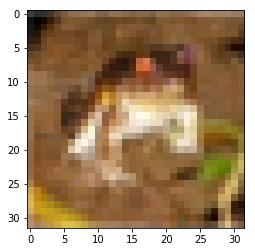

In [20]:
plt.imshow(X[0])

In [23]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(XNormal)

In [24]:
X_scaled = X_scaled.reshape(50000,3,32,32).transpose(0,2,3,1)

In [25]:
print(X_scaled.mean())
print(X_scaled.std())
#Close to Z(0,1) this is good

-6.307491566085824e-16
1.0000000000000007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


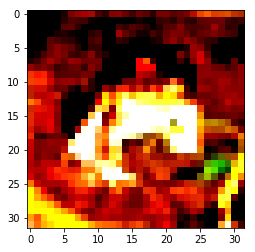

In [26]:
plt.imshow(X_scaled[0])

# Part 3

In [30]:
#Pavani had a great idea to do a Python Class to set the training and splitting up. I have modified it for my own code. 

class Cifar():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [batch1,batch2,batch3,batch4,batch5]
        self.test_batch = [batchT]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        print(train_len)
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]))
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        print(test_len)
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]))

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y


In [48]:
cf = Cifar()
cf.set_up_images()

Setting Up Training Images and Labels
50000
Setting Up Test Images and Labels
10000


In [50]:
input_ph = tf.placeholder(dtype = tf.float32, shape=[None,32,32,3])
output_ph = tf.placeholder(dtype=tf.float32, shape=[None,10])

hold_prob = tf.placeholder(tf.float32)

In [51]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [52]:
convo_1 = convolutional_layer(input_ph,shape=[3,3,3,64])
convo_1.get_shape()
convo_1_pooling = max_pool_2by2(convo_1)
convo_1_pooling.get_shape()

convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,64,128])
convo_2_pooling = max_pool_2by2(convo_2)

convo_3 = convolutional_layer(convo_2_pooling,shape=[5,5,128,256])
convo_3_pooling = max_pool_2by2(convo_3)

convo_4 = convolutional_layer(convo_3_pooling,shape=[5,5,256,512])
convo_4_pooling = max_pool_2by2(convo_4)
convo_4_flat = tf.contrib.layers.flatten(convo_4) 

full_layer_1 = tf.nn.relu(normal_full_layer(convo_4_flat,128))
full_1_dropout = tf.nn.dropout(full_layer_1,keep_prob=hold_prob)
full1 = tf.layers.batch_normalization(full_1_dropout)
print(full_layer_1.get_shape())

full_layer_2 = tf.nn.relu(normal_full_layer(full1,256))
full_2_dropout = tf.nn.dropout(full_layer_2,keep_prob=hold_prob)
full2 = tf.layers.batch_normalization(full_2_dropout)
print(full_layer_2.get_shape())

full_layer_3 = tf.nn.relu(normal_full_layer(full2,512))
full_3_dropout = tf.nn.dropout(full_layer_3,keep_prob=hold_prob)
full3 = tf.layers.batch_normalization(full_3_dropout)
print(full_layer_3.get_shape())

full_layer_4 = tf.nn.relu(normal_full_layer(full3,1024))
full_4_dropout = tf.nn.dropout(full_layer_4,keep_prob=hold_prob)
full4 = tf.layers.batch_normalization(full_4_dropout)
print(full_layer_4.get_shape())

(?, 128)
(?, 256)
(?, 512)
(?, 1024)


In [53]:
y_pred = normal_full_layer(full4,10)
y_pred.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [54]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_ph,logits=y_pred))

Adam_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

In [47]:
#TO-DO : reset session
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()



In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = cf.next_batch(100)
        sess.run(Adam_optimizer, feed_dict={input_ph: batch[0], output_ph:batch[1], hold_prob: 0.5})
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
           
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(output_ph,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print('Accuracy is:',sess.run(acc,feed_dict={input_ph:cf.test_images,output_ph:cf.test_labels,hold_prob:1.0}))
            print('Loss is:',sess.run(cross_entropy,feed_dict={input_ph:cf.test_images,output_ph:cf.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is: 0.0811
Loss is: 76.827324


Currently on step 100
Accuracy is: 0.1
Loss is: 2.3323302


Currently on step 200
Accuracy is: 0.1
Loss is: 2.3068688


Currently on step 300
Accuracy is: 0.1
Loss is: 2.306527


Currently on step 400
Accuracy is: 0.1
Loss is: 2.3178558


Currently on step 500
Accuracy is: 0.1
Loss is: 2.308215


Currently on step 600
Accuracy is: 0.1
Loss is: 2.304293


Currently on step 700
Accuracy is: 0.1
Loss is: 2.3072796


Currently on step 800
Accuracy is: 0.1
Loss is: 2.306044


Currently on step 900
Accuracy is: 0.1
Loss is: 2.3126004


Currently on step 1000
Accuracy is: 0.1
Loss is: 2.3084593


Currently on step 1100
Accuracy is: 0.1
Loss is: 2.3041856


Currently on step 1200
Accuracy is: 0.1
Loss is: 2.3068879


Currently on step 1300
Accuracy is: 0.1


In [ ]:
#My computer does not have the memory to complete the entire task.